**Instructors**: Prof. Antonio Ortega (aortega@usc.edu)

**Teaching Assistant**: Jiazhi Li (jiazhil@usc.edu)

**Book**: Watt, J., Borhani, R., & Katsaggelos, A. K. (2020). Machine learning refined: Foundations, algorithms, and applications. Cambridge University Press.

**Notebooks**: Written by Alexios Rustom (arustom@usc.edu)

# Fully Connected Neural Networks

In [149]:
import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import seaborn as sns
import copy
from sklearn.model_selection import train_test_split
readDataPath = '../readData/'
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib
from sklearn.neural_network import MLPRegressor
from autograd import grad

We describe multi-layer perceptrons which are recursively-built generalizations of the single hidden-layer units we have seen thus far. In this description we develop multi-layer units progressively, layer by layer, beginning with single hidden-layer units, providing algebraic, graphical, and computational perspectives on their construction. This is done to make the transition to multi-layer perceptrons easier. Afterwards we briefly touch on the biological plausibility of multi-layer perceptrons, and end this with an in depth description of how to efficiently implement multi-layer perceptrons in Python.

## Single-hidden-layer units

The general algebraic representation (i.e., the formula) of a general single-hidden-layer (or single-layer for short) unit is quite simple: a linear combination of input passed through a nonlinear 'activation' function

\begin{equation}
f^{(1)}\left(\mathbf{x}\right)=a\left(w^{\left(1\right)}_{0}+\underset{n=1}{\overset{N}{\sum}}{w^{\left(1\right)}_{n}\,x_n}\right)
\end{equation}

Here $a\left(\cdot\right)$ denotes an activation function and the superscripts on  $f$ and $w_0, w_1, \ldots, w_N$ indicate they represent a single-layer function and its internal weights respectively.

Because we will want to extend the single layer idea to create deeper - multilayer - perceptrons, we will find helpful to pull apart the sequence two operations used to construct it: the linear combination of input, passed through a nonlinear activation.  We refer to this manner of writing out the function as the *recursive recipe for creating single layer perceptron units* and summarize it below.

#### Recursive recipe for single-layer units

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">

<strong>1.</strong>&nbsp;&nbsp; Choose an activation function $a\left(\cdot\right)$<br>

<strong>2.</strong>&nbsp;&nbsp; Compute linear combination $v = w_{0}^{(1)}+{\sum_{n=1}^{N}}{w_{n}^{(1)}\,x_n}$ <br>

<strong>3.</strong>&nbsp;&nbsp; Pass the result through activation to form $a\left(v\right)$ <br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

#### <span style="color:#a50e3e;">Example. </span>  Illustrating the capacity of single layer units

Here we plot four instances of a single-layer unit using $\text{tanh}$ as nonlinear activation function. These take the form 

\begin{equation}
f^{(1)}(x) = \text{tanh}\left(w_0^{(1)} + w_1^{(1)}x\right)
\end{equation}

In each instance the internal parameters have been set randomly, giving each basis function a distinct shape.  

In [150]:
def get1dNN(num_layers, activation):
    
    parameters = []
    prev_num_hidden_units = 1
    
    for n in range(0,num_layers):
        layer_params = []
        
        num_hidden_units = 1
        if n < num_layers-1:
            num_hidden_units = 10

        for l in range(num_hidden_units):
            # choose first layer random weights to make nice single layer visualization
            c = 5*np.random.rand(1)[0] - 2.5
            v = -c - 2*np.sign(c)*np.random.rand(prev_num_hidden_units,1)
            
            c = np.random.randn(1)[0]
            v = np.random.randn(prev_num_hidden_units,1)
            
            # likewise, choose subsquent layer weights randomly as so for nice looking instances
            if n > 0:
                c = np.random.randn(1)[0]
                v = np.random.randn(prev_num_hidden_units,1)

            v = [s[0] for s in v]
            weights = [c,v]
            layer_params.append(weights)

        # store all weights 
        parameters.append(layer_params)

        prev_num_hidden_units = num_hidden_units
    return parameters

In [151]:
def show1dNN(num_layers, activation):
    fig = plt.figure(figsize = (9,3))
    m = 1
    while m < 5:
    # create instance of neural net basis element
        params = get1dNN(num_layers, activation)

        # create input
        x = np.linspace(-5,5,1000)
        x.shape = (1,len(x))
        f_prev = x

        # loop over each layer, pushing function composition, produce subsequent layer operations
        for n in range(0,num_layers):
            num_units = len(params[n])
            f_new = 0
            for u in range(0,num_units):
                # grab parameters        
                c = params[n][u][0]
                v = params[n][u][1]

                # loop over dimension of v, sum up components
                f = 0
                for i in range(0,len(v)):
                    f += f_prev[i,:]*v[i]

                # evaluate through activation
                temp = c + f
                f_temp = 0
                if activation == 'relu':
                    f_temp = a = np.maximum(np.zeros((np.shape(temp))),temp)
                if activation == 'tanh':
                    f_temp = a = np.tanh(temp)
                if type(f_new) == int:
                    f_new = f_temp
                else:
                    f_new = np.vstack([f_new,f_temp])

            # update previous layer evaluations f_prev
            f_prev = f_new
            if f_prev.ndim == 1:
                f_prev.shape = (1,len(f_prev))

        # plot the current instance
        f_m = f_prev

        # choose to plot interesting (non-zero) instance - if zero remake weights
        if np.std(f_m) > 0.01:
            ax = fig.add_subplot(1,4,m)
            ax.plot(x.ravel(),f_m.ravel()/max(f_m.ravel()),color = 'r',linewidth = 3)

            # clean up plot and show legend
            ax.set_title('$f^{\,(' + str(num_layers) + ')}(x)$', fontsize = 12)

            # clean up plot
            ax.grid(True, which='both')
            ax.axhline(y=0, color='k')
            ax.axvline(x=0, color='k')
            
            m+=1

<>:53: SyntaxWarning: invalid escape sequence '\,'
<>:53: SyntaxWarning: invalid escape sequence '\,'
/var/folders/h4/_y25lq397kbgj8ll1k7bwkww0000gn/T/ipykernel_28652/3612158050.py:53: SyntaxWarning: invalid escape sequence '\,'
  ax.set_title('$f^{\,(' + str(num_layers) + ')}(x)$', fontsize = 12)


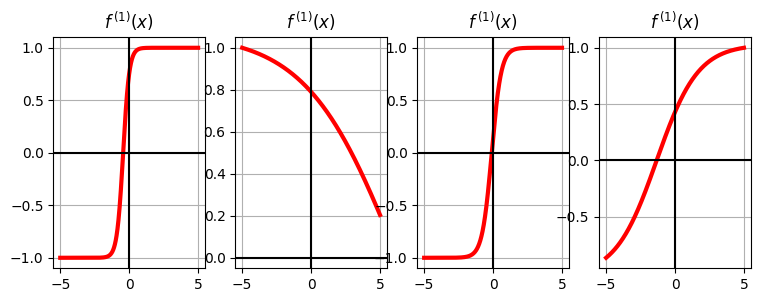

In [152]:
num_layers = 1; activation = 'tanh';
show1dNN(num_layers, activation)

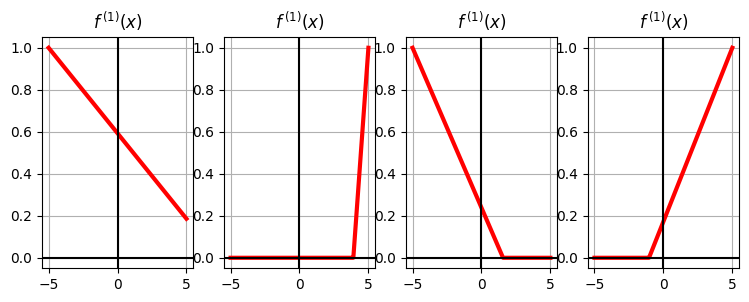

In [153]:
num_layers = 1; activation = 'relu';
show1dNN(num_layers, activation)

If we form a model using $B = U_1$ such single-hidden-layer units as

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f^{(1)}_1\left(\mathbf{x}\right)w_1 + \cdots + f^{(1)}_{U_1}\left(\mathbf{x}\right)w_{U_1}
\end{equation}

whose $j^{th}$ element takes the form $f^{(1)}_j\left(\mathbf{x}\right)=a\left(w^{\left(1\right)}_{0,\,j}+\underset{n=1}{\overset{N}{\sum}}{w^{\left(1\right)}_{n,\,j}\,x_n}\right)$, the parameter set $\Theta$ contains not only the weights of the final linear combination $w_0$ through $w_{U_1}$, but all parameters internal to each $f_j$ as well. 

Note that by defining:

$$
\mathring{\mathbf{x}}=\left[\begin{array}{c}
1\\
x_{1}\\
\vdots\\
x_{N}
\end{array}\right] \quad
\mathbf{W}_{1}=\left[\begin{array}{cccc}
w_{0,1}^{\left(1\right)} & w_{0,2}^{\left(1\right)} & \cdots & w_{0,U_{1}}^{\left(1\right)}\\
w_{1,1}^{\left(1\right)} & w_{1,2}^{\left(1\right)} & \cdots & w_{1,U_{1}}^{\left(1\right)}\\
\vdots & \vdots & \ddots & \vdots\\
w_{N,1}^{\left(1\right)} & w_{N,2}^{\left(1\right)} & \cdots & w_{N,U_{1}}^{\left(1\right)}
\end{array}\right] \quad
\mathbf{w}_{2} = 
\begin{bmatrix}
\
w_{0} \\
w_{1} \\
\vdots \\
w_{U_1}
\end{bmatrix}
$$

our model can be written more simply, compactly, and conveniently as 

$$
\text{model}\left(\mathbf{x},\Theta\right) = \mathbf{w}_2^T \mathring{\mathbf{a}}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right)
$$

In order to keep ourselves organized and better prepared to understand *deeper* network units, it is quite helpful to **compactify** this visualization by defining

$$
\mathring{\mathbf{x}}=\left[\begin{array}{c}
1\\
x_{1}\\
\vdots\\
x_{N}
\end{array}\right] \qquad \text{and} \qquad 
\mathbf{W}_{1}=\left[\begin{array}{cccc}
w_{0,1}^{\left(1\right)} & w_{0,2}^{\left(1\right)} & \cdots & w_{0,U_{1}}^{\left(1\right)}\\
w_{1,1}^{\left(1\right)} & w_{1,2}^{\left(1\right)} & \cdots & w_{1,U_{1}}^{\left(1\right)}\\
\vdots & \vdots & \ddots & \vdots\\
w_{N,1}^{\left(1\right)} & w_{N,2}^{\left(1\right)} & \cdots & w_{N,U_{1}}^{\left(1\right)}
\end{array}\right]. 
$$

With this notation note how the matrix-vector product $\mathbf{W}_{1}^T\,\mathbf{x}$ contains every linear combination *internal* to our $U_1$ nonlinear activation units.  In other words, it has dimensions $U_1 \times 1$, and its $j^{th}$ entry is precisely the linear combination of the input data internal to the $j^{th}$ unit as

\begin{equation}
\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right)_j = w^{\left(1\right)}_{0,\,j}+\underset{n=1}{\overset{N}{\sum}}{w^{\left(1\right)}_{n,\,j}\,x_n} \,\,\,\,\,\,\,\,\,\,\,\,\,\,\, j=1,...,U_1.
\end{equation}

Lets now extend our notation to define $\mathbf{a}$ as the vector function that takes in a general $d \times 1$ vector $\mathbf{v}$ and returns as activation of each of its entries

$$
\mathbf{a}\left(\mathbf{v}\right)=\left[\begin{array}{c}
a\left(v_{1}\right)\\
\vdots\\
a\left(v_{d}\right)
\end{array}\right].
$$

With this notation the vector-activation of the matrix-vector product $\mathbf{a}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right)$ is a $U_1 \times 1$ vector contains all $U_1$ single layer units as
$$
\mathbf{a}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right)_j  =  a\left(w^{\left(1\right)}_{0,\,j}+\underset{n=1}{\overset{N}{\sum}}{w^{\left(1\right)}_{n,\,j}\,x_n^{\,}}\right) \,\,\,\,\,\,\,\,\,\,\,\,\,\,\, j=1,...,U_1.  \\
$$

Using compact notation to denote the weights of the linear combination as

\begin{equation}
\mathbf{w}_{2} = 
\begin{bmatrix}
\
w_{0} \\
w_{1} \\
\vdots \\
w_{U_1}
\end{bmatrix}
\end{equation}

and extend our vector $\mathbf{a}$ by tacking a $1$ on top of it - denoted as $\mathring{\mathbf{a}}$ - we can then write out our model quite compactly as

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = \mathbf{w}_2^T \mathring{\mathbf{a}}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right).
\end{equation}


This more compact algebraic depiction lends itself to much more easily digestible, and extended, visual depictions as illustrated below. 

## Two hidden-layer units 

To create a two-layer unit we *recurse* on the idea of the single-layer unit detailed previously, by first constructing a set of $U_1$ single layer units and treat them as input: we take their linear combination and pass the result through a nonlinear activation


\begin{equation}
f^{\left(2\right)}\left(\mathbf{x}\right)=a\left(w^{\left(2\right)}_{0}+\underset{i=1}{\overset{U_1}{\sum}}{w^{\left(2\right)}_{i}}\,f^{(1)}_i\left(\mathbf{x}\right)\right)
\end{equation}

 The recursive nature of this two hidden-layer unit can be also seen in the 'recursive recipe' given below.  

#### Recursive rescipe for two layer perceptron units

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">

<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> Activation function $a\left(\cdot\right)$, number of single layer units $U_1$<br>

<strong>2:</strong>&nbsp;&nbsp;  Construct single layer units:  $\,\,\,\,\,\,\,\,\,f^{(1)}_i\left(\mathbf{x}\right)$ for $i=1,\,...,U_1$ <br>

<strong>3:</strong>&nbsp;&nbsp; Compute linear combination:   $\,\,\,\,\,\,\, v = w_{0}^{(2)}+{\sum_{i=1}^{U_1}}{w_{i}^{(2)}\,f^{(1)}_i}\left(\mathbf{x}\right)$ <br>

<strong>4:</strong>&nbsp;&nbsp; Pass result through activation: $\,\,\,\, a\left(v\right)$ <br>

<strong>5:</strong>&nbsp;&nbsp; <strong>output:</strong> Two layer unit $\,\, a\left(v\right)$<br/>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

#### <span style="color:#a50e3e;">Example. </span> Illustrating the capacity of two-layer units

- We plot four instances of a two-layer function using $\text{tanh}$ as activation, akin to what we did in the previous example.

- All weights are again set randomly in each instance.

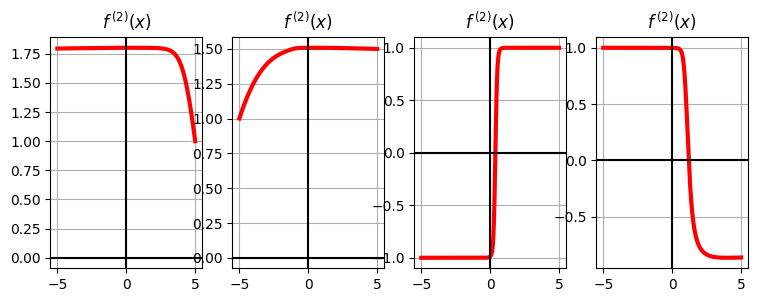

In [154]:
num_layers = 2; activation = 'tanh';
show1dNN(num_layers, activation)

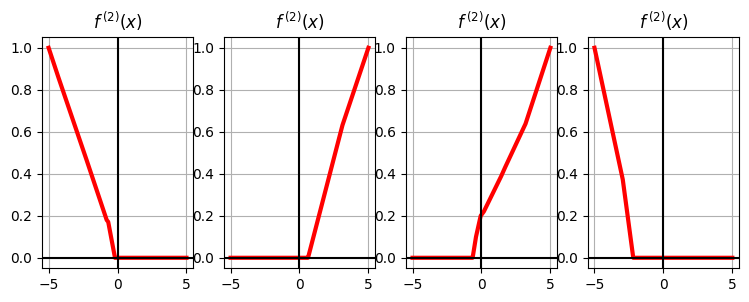

In [155]:
num_layers = 2; activation = 'relu';
show1dNN(num_layers, activation)

In general if we wish to create a model using $B = U_2$ such two layer units we have

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f^{(2)}_1\left(\mathbf{x}\right)w_1 + \cdots + f^{(2)}_{U_2}\left(\mathbf{x}\right)w_{U_2}.
\end{equation}

Here the parameter set $\Theta$ both those weights internal to the units as well as the final linear combination weights.

Notice in this case that each two layer unit now has its own unique internal parameters in the linear combination of single layer units (but the weights intnernal to the single layer units are the same for each two layer unit we define).  The $j^{th}$ of which looks like 

\begin{equation}
f^{\left(2\right)}_j\left(\mathbf{x}\right)=a\left(w^{\left(2\right)}_{0.j}+\underset{i=1}{\overset{U_1}{\sum}}{w^{\left(2\right)}_{i,j}}\,f^{(1)}_i\left(\mathbf{x}\right)\right)
\end{equation}

Once again, carrying over our compact notation and defining:

$$
\mathbf{W}_{2}=\left[\begin{array}{cccc}
w_{0,1}^{\left(2\right)} & w_{0,2}^{\left(2\right)} & \cdots & w_{0,U_{2}}^{\left(2\right)}\\
w_{1,1}^{\left(2\right)} & w_{1,2}^{\left(2\right)} & \cdots & w_{1,U_{2}}^{\left(2\right)}\\
\vdots & \vdots & \ddots & \vdots\\
w_{U_1,1}^{\left(2\right)} & w_{U_1,2}^{\left(2\right)} & \cdots & w_{U_1,U_{2}}^{\left(2\right)}
\end{array}\right] \quad
\mathbf{w}_{3} = 
\begin{bmatrix}
\
w_{0} \\
w_{1} \\
\vdots \\
w_{U_2}
\end{bmatrix}
$$

we can write our model much more compactly as 

$$
\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = \mathbf{w}_3^T\mathring{\mathbf{a}}\left(\mathbf{W}_2^T\mathring{\mathbf{a}}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right)\right)
\end{equation}$$

As with the single layer model here it is also helpful to compactify both our notation and the corresponding visualization of a two layer model in order to simplify our understanding and make the concept easier to weild.  Using the same notation introduced in the previous Subsection, we can compactly designate the output of our $U_1$ single layer units / first hidden layer as

\begin{equation}
\text{output of first hidden layer} \,\,\,\,\,\,\,\,\, \mathring{\mathbf{a}}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right).
\end{equation}

Then, following the same pattern here to compactly express our second layer units, we can condense all internal weights of our $U_2$ second layer units column-wise into a $\left(U_1 +1 \right)\times U_2$ of the form

$$
\mathbf{W}_{2}=\left[\begin{array}{cccc}
w_{0,1}^{\left(2\right)} & w_{0,2}^{\left(2\right)} & \cdots & w_{0,U_{2}}^{\left(2\right)}\\
w_{1,1}^{\left(2\right)} & w_{1,2}^{\left(2\right)} & \cdots & w_{1,U_{2}}^{\left(2\right)}\\
\vdots & \vdots & \ddots & \vdots\\
w_{U_1,1}^{\left(2\right)} & w_{U_1,2}^{\left(2\right)} & \cdots & w_{U_1,U_{2}}^{\left(2\right)}
\end{array}\right]
$$

This allows us to likewise express the output of our two layer units / second hidden layer compactly as

\begin{equation}
\text{output of second hidden layer} \,\,\,\,\,\,\,\,\, \mathring{\mathbf{a}}\left(\mathbf{W}_2^T\mathring{\mathbf{a}}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right)\right)
\end{equation}

and here the recursive nature of the two layer unit is on full display.  Remember that we use the notation $\mathring{\mathbf{a}}$ somewhat loosely as a function in the sense that it simply represents taking the nonlinear activation - elementwise - of whatever vector is input into it.  In the first layer this vector $\mathbf{W}_1^T\mathring{\mathbf{x}}$ has size $\left(U_1 + 1\right) \times 1$, in the second its input $\mathbf{W}_2^T \mathring{\mathbf{a}}$ has size $\left(U_2 + 1\right) \times 1$.

Finally we can then compactly express our generic two hidden-layer model compactly by denoting the final linear combination weights as

\begin{equation}
\mathbf{w}_{3} = 
\begin{bmatrix}
\
w_{0} \\
w_{1} \\
\vdots \\
w_{U_2}
\end{bmatrix}
\end{equation}

which allows us to write the full two layer model, a linear combination of the output from our second hidden layer, as 

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = \mathbf{w}_3^T\mathring{\mathbf{a}}\left(\mathbf{W}_2^T\mathring{\mathbf{a}}\left(\mathbf{W}_{1}^T\,\mathring{\mathbf{x}}\right)\right)
\end{equation}

## General multi-layer perceptron units

By recursing on the pattern we have seen above in describing single and two layer perceptron units we can construct arbitrary *multi-layer perceptrons*, with each added hidden layer increasing the capacity of a multi-layer unit.  In the figure below we show the graphical representation of a general $L$ hidden-layer unit, or $L$ layer unit for short. To construct a network unit like this with an arbitrary number of layers we simply recurse on the pattern we have seen established above $L-1$ times - with the resulting $L$ hidden-layer unit taking as input a number $U_{L-1}$ of $L-1$ hidden-layer units.

The algebraic form of an $L$-layer unit $f^{\left(L\right)}\left(\mathbf{x}\right)$ is given by the formula 

\begin{equation}
f^{\left(L\right)}\left(\mathbf{x}\right)=a\left(w^{\left(L\right)}_{0}+\underset{i=1}{\overset{U_{L-1}}{\sum}}{w^{\left(L\right)}_{i}}\,f^{(L-1)}_i\left(\mathbf{x}\right)\right)
\end{equation}

which reflects the recursive nature of the $L$ layer unit algebraically.

#### Recursive rescipe for $L$-layer units

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">

<strong>1. </strong>&nbsp;&nbsp; Choose an activation function $a\left(\cdot\right)$<br>

<strong>2. </strong>&nbsp;&nbsp;  Construct $U_{L-1}$ number of $(L-1)$-layer units $f^{(L-1)}_i\left(\mathbf{x}\right)$ for $i=1,\,...,U_{L-1}$ <br>

<strong>3. </strong>&nbsp;&nbsp; Compute the linear combination $v = w_{0}^{(L)}+{\sum_{i=1}^{U_{L-1}}}{w_{i}^{(L)}\,f^{(L-1)}_i}\left(\mathbf{x}\right)$ <br>

<strong>4. </strong>&nbsp;&nbsp; Pass the result through activation and form $a\left(v\right)$ <br>


<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

#### <span style="color:#a50e3e;">Example. </span> Illustrating the capacity of three-layer units 

- In this example we show four instances of a three-layer perceptron unit with $\text{tanh}$ activation functions.

- Often a model composed of units that have three or more hidden layers is called a *deep network*. 

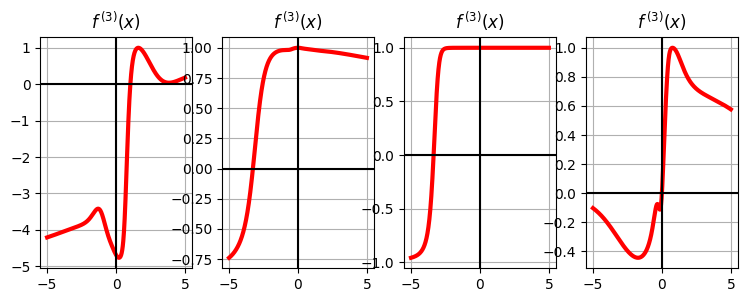

In [156]:
num_layers = 3; activation = 'tanh';
show1dNN(num_layers, activation)

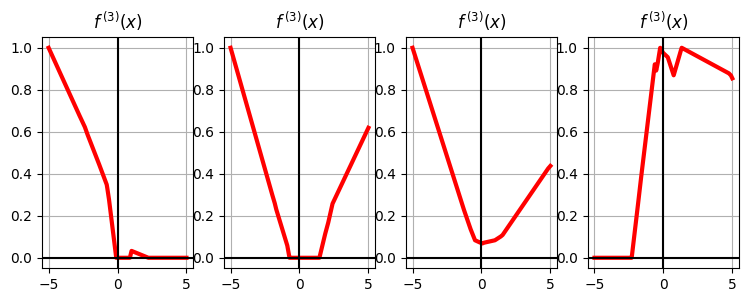

In [157]:
num_layers = 3; activation = 'relu';
show1dNN(num_layers, activation)

In general we can produce a model consisting of $B = U_L$ such $L$ layer units  

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f^{(L)}_1\left(\mathbf{x}\right)w_1 + \cdots + f^{(L)}_{U_L}\left(\mathbf{x}\right)w_{U_L}
\end{equation}

where parameter set $\Theta$ both those weights internal to the units as well as the final linear combination weights.  The $j^{th}$ unit takes the familiar form

\begin{equation}
f^{\left(L\right)}_j\left(\mathbf{x}\right)=a\left(w^{\left(L\right)}_{0.j}+\underset{i=1}{\overset{U_{L-1}}{\sum}}{w^{\left(L\right)}_{i,j}}\,f^{(L-1)}_i\left(\mathbf{x}\right)\right).
\end{equation}

To simplify our understanding of this general network architecture we can use precisely the same compact notation and visualizations we have introduced in the simpler context of single and two layer networks.  In complete analogy to the way we compactly represented two layer networks above, we can denote the output of the $\left(L\right)^{th}$ layer compactly as

\begin{equation}
\text{output of $\left(L\right)^{th}$ hidden layer} \,\,\,\,\,\,\,\,\, \mathring{\mathbf{a}}\left(\mathbf{W}_{L}^T\,\mathring{\mathbf{a}}\left(  \mathbf{W}_{L-1}^T \mathring{\mathbf{a}}\left( \cdots \mathbf{W}_{1}^T\mathring{\mathbf{x}}\right)\cdots\right)\right)
\end{equation}

which displays rather compactly the recursive nature of the final hidden layer's output.  Here - as we found previously - the dimensions of the first two layer weight matrices $\mathbf{W}_1$ and $\mathbf{W}_2$ are is $\left(N + 1\right) \times U_1$ and $\left(U_1 + 1\right) \times \left(U_2 + 1\right)$, respectively.  By the same logic the dimensions of the $l^{th}$ such matrix $\mathbf{W}_l$ is $\left(U_{l-1} + 1\right) \times U_l$. 

Denoting the weights of the final linear combination as

\begin{equation}
\mathbf{w}_{L+1} = 
\begin{bmatrix}
\
w_{0} \\
w_{1} \\
\vdots \\
w_{U_L}
\end{bmatrix}
\end{equation}

we can express the model of $L$ layer units compactly as 


\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = \mathbf{w}_{L+1}^T\mathring{\mathbf{a}}\left(\mathbf{W}_{L}^T\,\mathring{\mathbf{a}}\left(  \mathbf{W}_{L-1}^T \mathring{\mathbf{a}}\left( \cdots \mathbf{W}_{1}^T\mathring{\mathbf{x}}\right)\cdots\right)\right)
\end{equation}

- Once again, we can express the model of $L$-layer units compactly as 


\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = \mathbf{w}_{L+1}^T\mathring{\mathbf{a}}\left(\mathbf{W}_{L}^T\,\mathring{\mathbf{a}}\left(  \mathbf{W}_{L-1}^T \mathring{\mathbf{a}}\left( \cdots \mathbf{W}_{1}^T\mathring{\mathbf{x}}\right)\cdots\right)\right)
\end{equation}

- This compact form allows for more condensed and convenient graphical representations of our model as depicted below.

## Selecting proper network architectures

We have now seen a general and recursive method of constructing arbitrarily deep multi-layer perceptrons, but many curiosities and technical issues need be addressed, and are the subject of subsequent Sections of this Chapter.  These include the choice of activation function, popular cross-validation methods for models employing network units, a variety of issues to discuss regarding optimization including the notion of *batch normalization*, and the notion of *backpropogation*. 

However, one fundamental question can - at least in general - be addressed now, which is (the question of) how in general we choose the number of units and layers for a network architecture.  As with the choice of proper universal approximator in general, typically we do not know apriori what sort of network architecture (i.e., how many units, hidden layers, nor the shape of each hidden layer) will work best for a given dataset ahead of time.  In order to determine the best architecture for use with a given dataset we must - in general - cross-validate an array of choices. 

In doing so it must be kept in mind that, generally speaking, the capacity gained by adding new individual units to a network is much smaller relative to the capacity gained by addition of new hidden layers (see Figure below).

#### <span style="color:#a50e3e;">Example. </span>  Nonlinear two-class classification example using multilayer perceptrons

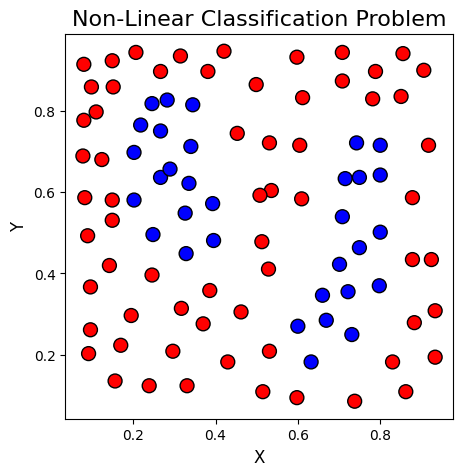

In [158]:
csvFile = readDataPath + '2_eggs.csv'
data = np.loadtxt(csvFile,delimiter = ',')
x = data[:-1,:].T
y = data[-1,:]
data = pd.DataFrame(data)
data = data.T
data.columns=["X", "Y", "Label"]
plt.figure(figsize=(5, 5))
col = np.where(data["Label"]==1,'r','b')
plt.scatter(data["X"],data["Y"],s=100,c=col, edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Non-Linear Classification Problem', fontsize=16)
plt.show()

- Number of hidden layers: 4
- Number of units per layer: 10
- Activation: $\text{relu}$

In [159]:
scaler = StandardScaler()
scaler.fit(x)
x_transformed = scaler.transform(x)

In [160]:
#X_train, X_test, y_train, y_test = train_test_split(x_transformed, y, test_size=0.3)

In [161]:
clf = MLPClassifier(hidden_layer_sizes=(10,10,10),
                    activation='tanh',
                    solver='adam',
                    verbose=True,
                    max_iter=10000)

In [162]:
clf.fit(x_transformed,y)
#clf.fit(X_train,y_train)

Iteration 1, loss = 0.66758885
Iteration 2, loss = 0.66514943
Iteration 3, loss = 0.66280490
Iteration 4, loss = 0.66055751
Iteration 5, loss = 0.65840914
Iteration 6, loss = 0.65636118
Iteration 7, loss = 0.65441437
Iteration 8, loss = 0.65256871
Iteration 9, loss = 0.65082357
Iteration 10, loss = 0.64917767
Iteration 11, loss = 0.64762912
Iteration 12, loss = 0.64617542
Iteration 13, loss = 0.64481342
Iteration 14, loss = 0.64353935
Iteration 15, loss = 0.64234887
Iteration 16, loss = 0.64123712
Iteration 17, loss = 0.64019881
Iteration 18, loss = 0.63922836
Iteration 19, loss = 0.63831997
Iteration 20, loss = 0.63746772
Iteration 21, loss = 0.63666571
Iteration 22, loss = 0.63590816
Iteration 23, loss = 0.63518947
Iteration 24, loss = 0.63450427
Iteration 25, loss = 0.63384752
Iteration 26, loss = 0.63321447
Iteration 27, loss = 0.63260077
Iteration 28, loss = 0.63200242
Iteration 29, loss = 0.63141582
Iteration 30, loss = 0.63083775
Iteration 31, loss = 0.63026538
Iteration 32, los

MLPClassifier(activation='tanh', hidden_layer_sizes=(10, 10, 10),
              max_iter=10000, verbose=True)

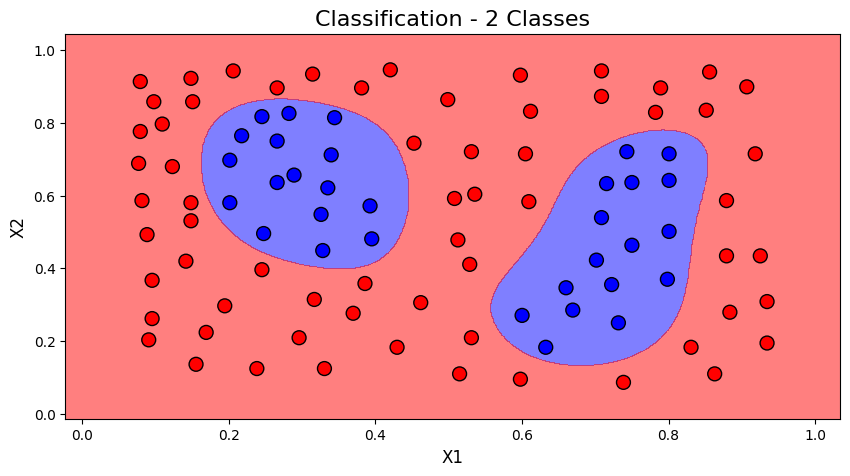

In [163]:
fig, axs = plt.subplots(1,1, figsize = (10,5))
h = 0.001
x_min, x_max = x[:,0].min() - 0.1, x[:,0].max() + 0.1
y_min, y_max = x[:,1].min() - 0.1, x[:,1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
x_mesh_transformed = scaler.transform(np.c_[xx.ravel(), yy.ravel()])
Z = clf.predict(x_mesh_transformed)
#Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) 
Z = Z.reshape(xx.shape)
axs.contourf(xx, yy, Z+1, levels = range(0,3+1), alpha=0.5, colors = ['blue', 'red', 'green'])
axs.set_xlabel('X1', fontsize = 12)
axs.set_ylabel('X2', fontsize = 12)
axs.set_title('Classification - 2 Classes', fontsize=16)
axs.scatter(data["X"],data["Y"],s=100,c=col, edgecolors='k')
plt.show()

#### <span style="color:#a50e3e;">Example. </span> Nonlinear multiclass classification using two layer units

- Number of hidden layers: 2
- Number of units per layer: $U_1 = 12$ and $U_2 = 5$
- Activation: $\text{tanh}$

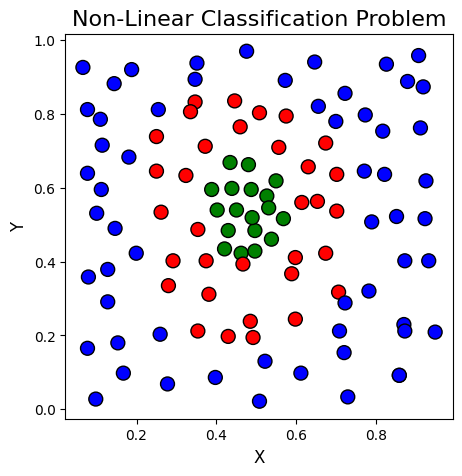

In [164]:
csvname = readDataPath + '3_layercake_data.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:].T
y = data[-1,:]
data = pd.DataFrame(data)
data = data.T
data.columns=["X", "Y", "Label"]
plt.figure(figsize=(5, 5))
col_3C = np.where(data['Label']==0,'b',np.where(data['Label']==1,'r',np.where(data['Label']==2,'g', 'k')))
plt.scatter(data["X"],data["Y"],s=100,c=col_3C, edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Non-Linear Classification Problem', fontsize=16)
plt.show()

In [165]:
scaler = StandardScaler()
scaler.fit(x)
x_transformed = scaler.transform(x)
#X_train, X_test, y_train, y_test = train_test_split(x_transformed, y, test_size=0.3)
clf = MLPClassifier(hidden_layer_sizes=(12,5),
                    activation='tanh',
                    solver='adam',
                    verbose=True,
                    max_iter=10000)
clf.fit(x_transformed,y)

Iteration 1, loss = 1.16090258
Iteration 2, loss = 1.15641505
Iteration 3, loss = 1.15198555
Iteration 4, loss = 1.14761562
Iteration 5, loss = 1.14330634
Iteration 6, loss = 1.13905818
Iteration 7, loss = 1.13487096
Iteration 8, loss = 1.13074438
Iteration 9, loss = 1.12667837
Iteration 10, loss = 1.12267313
Iteration 11, loss = 1.11872897
Iteration 12, loss = 1.11484628
Iteration 13, loss = 1.11102541
Iteration 14, loss = 1.10726665
Iteration 15, loss = 1.10357018
Iteration 16, loss = 1.09993611
Iteration 17, loss = 1.09636443
Iteration 18, loss = 1.09285505
Iteration 19, loss = 1.08940783
Iteration 20, loss = 1.08602257
Iteration 21, loss = 1.08269902
Iteration 22, loss = 1.07943690
Iteration 23, loss = 1.07623587
Iteration 24, loss = 1.07309556
Iteration 25, loss = 1.07001554
Iteration 26, loss = 1.06699534
Iteration 27, loss = 1.06403445
Iteration 28, loss = 1.06113231
Iteration 29, loss = 1.05828830
Iteration 30, loss = 1.05550179
Iteration 31, loss = 1.05277209
Iteration 32, los

MLPClassifier(activation='tanh', hidden_layer_sizes=(12, 5), max_iter=10000,
              verbose=True)

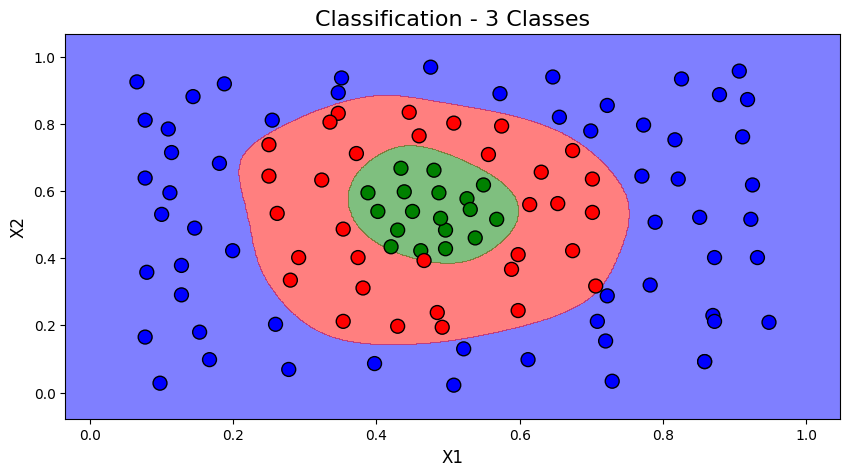

In [166]:
fig, axs = plt.subplots(1,1, figsize = (10,5))
h = 0.001
x_min, x_max = x[:,0].min() - 0.1, x[:,0].max() + 0.1
y_min, y_max = x[:,1].min() - 0.1, x[:,1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
x_mesh_transformed = scaler.transform(np.c_[xx.ravel(), yy.ravel()])
Z = clf.predict(x_mesh_transformed)
#Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) 
Z = Z.reshape(xx.shape)
axs.contourf(xx, yy, Z+1, levels = range(0,3+1), alpha=0.5, colors = ['blue', 'red', 'green'])
axs.set_xlabel('X1', fontsize = 12)
axs.set_ylabel('X2', fontsize = 12)
axs.set_title('Classification - 3 Classes', fontsize=16)
axs.scatter(data["X"],data["Y"],s=100,c=col_3C, edgecolors='k')
plt.show()

#### <span style="color:#a50e3e;">Example. </span>  Learning a nonlinear manifold using multilayer perceptron encoding/decoding functions

- Number of hidden layers (for both encoder and decoder): 3
- Number of units per layer: 10
- Activation: $\text{tanh}$

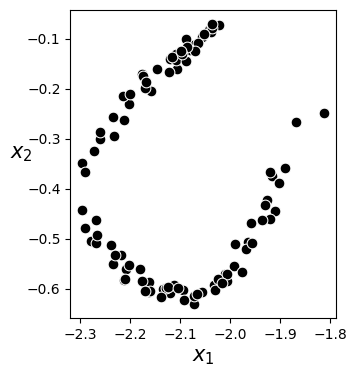

In [167]:
X = np.loadtxt(readDataPath + 'universal_autoencoder_samples.csv',delimiter=',')
# scatter dataset
fig = plt.figure(figsize = (9,4))
gs = matplotlib.gridspec.GridSpec(1,1) 
ax = plt.subplot(gs[0],aspect = 'equal'); 
ax.set_xlabel(r'$x_1$',fontsize = 15);ax.set_ylabel(r'$x_2$',fontsize = 15,rotation = 0);
ax.scatter(X[0,:],X[1,:],c = 'k',s = 60,linewidth = 0.75,edgecolor = 'w')
plt.show()

In [168]:
X_data = copy.deepcopy(X.T)
scaler.fit(X_data)
X_transformed = scaler.transform(X_data)

In [169]:
n_input = 2*1

# Encoder structure
n_encoder1 = 10
n_encoder2 = 10
n_encoder3 = 10

n_latent = 1

# Decoder structure
n_decoder3 = 10
n_decoder2 = 10
n_decoder1 = 10

In [170]:
reg = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_encoder3, n_latent,n_decoder3, n_decoder2, n_decoder1), 
                activation = 'tanh', 
                solver = 'adam', 
                learning_rate_init = 0.0001, 
                max_iter = 30000, 
                tol = 0.0000001, 
                verbose = True)

In [171]:
reg.fit(X_transformed, X_transformed)

Iteration 1, loss = 0.75612301
Iteration 2, loss = 0.75437968
Iteration 3, loss = 0.75264314
Iteration 4, loss = 0.75091350
Iteration 5, loss = 0.74919088
Iteration 6, loss = 0.74747539
Iteration 7, loss = 0.74576714
Iteration 8, loss = 0.74406624
Iteration 9, loss = 0.74237278
Iteration 10, loss = 0.74068687
Iteration 11, loss = 0.73900860
Iteration 12, loss = 0.73733807
Iteration 13, loss = 0.73567536
Iteration 14, loss = 0.73402055
Iteration 15, loss = 0.73237372
Iteration 16, loss = 0.73073495
Iteration 17, loss = 0.72910431
Iteration 18, loss = 0.72748186
Iteration 19, loss = 0.72586766
Iteration 20, loss = 0.72426177
Iteration 21, loss = 0.72266425
Iteration 22, loss = 0.72107513
Iteration 23, loss = 0.71949446
Iteration 24, loss = 0.71792228
Iteration 25, loss = 0.71635862
Iteration 26, loss = 0.71480351
Iteration 27, loss = 0.71325698
Iteration 28, loss = 0.71171904
Iteration 29, loss = 0.71018971
Iteration 30, loss = 0.70866901
Iteration 31, loss = 0.70715695
Iteration 32, los

MLPRegressor(activation='tanh', hidden_layer_sizes=(10, 10, 10, 1, 10, 10, 10),
             learning_rate_init=0.0001, max_iter=30000, tol=1e-07,
             verbose=True)

In [172]:
x_reconst = scaler.inverse_transform(reg.predict(X_transformed))

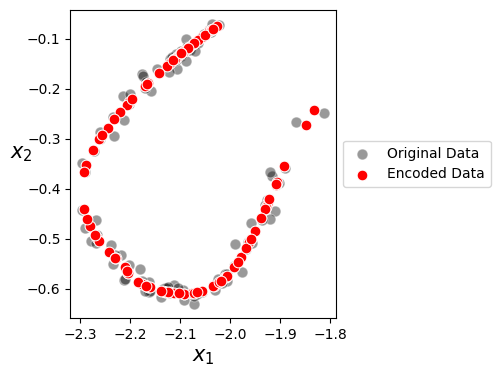

In [173]:
fig = plt.figure(figsize = (9,4))
gs = matplotlib.gridspec.GridSpec(1,1) 
ax = plt.subplot(gs[0],aspect = 'equal'); 
ax.set_xlabel(r'$x_1$',fontsize = 15);ax.set_ylabel(r'$x_2$',fontsize = 15,rotation = 0);
ax.scatter(X_data[:,0],X_data[:,1],c = 'k',s = 60,linewidth = 0.75,edgecolor = 'w', alpha=0.4, label = 'Original Data')
ax.scatter(x_reconst[:,0],x_reconst[:,1],c = 'r',s = 60,linewidth = 0.75,edgecolor = 'w', label = 'Encoded Data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Activation functions

- In principle one can use any function as an activation for a multi-layer perceptron.

- For a while activations were chosen largely based on their biological plausibility, since this is the perspective in which neural networks themselves were largely regarded.

- Today activation functions are chosen based on practical considerations like our ability to properly optimize multi-layer perceptron models which employ them as well as (of course) the general performance they provide.

#### <span style="color:#a50e3e;">Example. </span>  The step and sigmoid activations & The rectified linear unit (ReLU) activation

- A simpler function than a sigmoid (which involves both the use of a $\text{log}$ and exponential function), the ReLU function (and its relatives) have quickly become the most popular activation functions in use today.

- The ReLU function does not suffer from the same sort of vanishing gradient problem that the sigmoid does, as its derivative only maps negative values to zero.

- However, some care still must be taken when initializing and training a network employing ReLU activations.

- For example, a multi-layer perceptron employing ReLU activations should be initialized away from the origin to avoid too many of the units (and their gradients) from vanishing.

In [174]:
def activation1(w):
    a = 1/(1 + np.exp(-5*w))
    return a

In [175]:
def activation2(w):
    a = np.maximum(0,w)
    return a

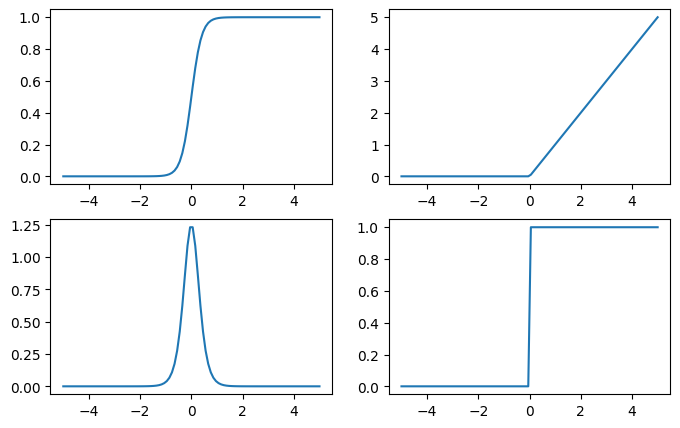

In [176]:
# create input and functions to plot
w = np.linspace(-5,5,100)
a = activation1(w)
deg = 20
# a2 = my_act(w)
a2 = activation2(w)

# create derivatives to plot
der = grad(activation1)
b = np.array([der(v) for v in w])
der2 = grad(activation2)
b2 =  np.array([der2(v) for v in w])

### figure construction ###
# initialize figure
fig = plt.figure(figsize = (8,5))

# create subplot with 1 panel
gs = matplotlib.gridspec.GridSpec(2, 2) 
ax = plt.subplot(gs[0]); 
ax.plot(w,a)
ax = plt.subplot(gs[1]); 
ax.plot(w,a2)

ax = plt.subplot(gs[2]); 
ax.plot(w,b)
ax = plt.subplot(gs[3]); 
ax.plot(w,b2)
plt.show()

#### <span style="color:#a50e3e;">Example. </span>  The maxout activation

The *maxout* activation is a relative of the ReLU that takes the maximum of two linear combinations of the input (instead of one linear combination and zero, as is the case with ReLU)

\begin{equation}
a(x) = \text{max}(v_0 + v_1x, \,w_0 + w_1x) \\
\end{equation}

In [177]:
def activation3(w,v):
    a = np.maximum(w,v)
    return a

In [178]:
x = np.linspace(-5,5,100)

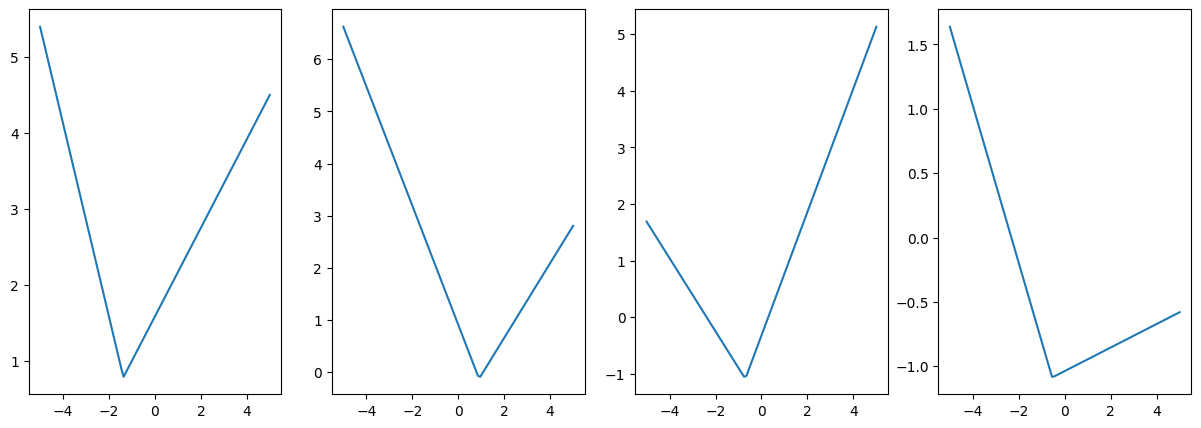

In [179]:
fig = plt.figure(figsize = (15,5))
for i in range(1,5):
    w_00 = np.random.randn(1); w_01 = np.random.randn(1)
    w_10 = np.random.randn(1); w_11 = np.random.randn(1)
    fm0 = w_00 + w_01*x; fm0_table = np.stack((x,fm0),axis = 1)
    fm1 = w_10 + w_11*x; fm1_table = np.stack((x,fm1),axis = 1)
    a = activation3(fm0,fm1)
    ax = fig.add_subplot(1,4,i)
    ax.plot(x,a)

Multi-layer perceptron architectures employing the maxout activation tend to have certain advantages over those employing $\text{tanh}$ and ReLU activations, including:

 - fewer issues with problematic initialization (e.g., values close to or equal to zero for the *ReLU* activation are bad because the relu is minimized at zero)
 - fewer issues with gradients vanishing
 - empirically faster convergence with far fewer gradient descent steps

These advantages come with a simple price: the maxout activation has twice as many internal parameters as either the ReLU or $\text{tanh}$.

## Optimization of Neural Networks

In [180]:
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.optim import RMSprop
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import random


In [181]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [182]:
x, y = torch.load( readDataPath + 'MNIST/processed/training.pt')

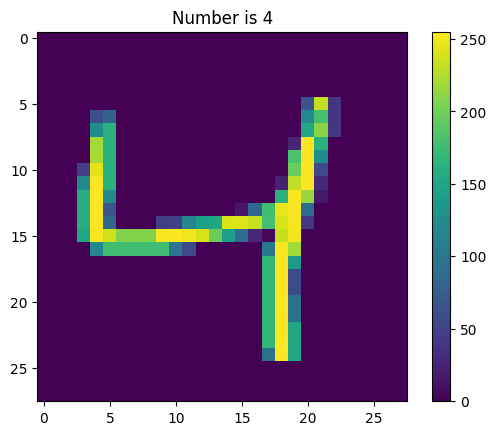

In [183]:
plt.imshow(x[2].numpy())
plt.title(f'Number is {y[2].numpy()}')
plt.colorbar()
plt.show()

In [184]:
y_new = F.one_hot(y, num_classes=10)
y_new.shape

torch.Size([60000, 10])

In [185]:
x.shape

torch.Size([60000, 28, 28])

In [186]:
x.view(-1,28**2).shape

torch.Size([60000, 784])

In [187]:
class CTDataset(Dataset):
    def __init__(self, filepath):
        self.x, self.y = torch.load(filepath)
        self.x = self.x / 255. #data normalization
        self.y = F.one_hot(self.y, num_classes=10).to(float)
    def __len__(self): #how many images: 60000
        return self.x.shape[0]
    def __getitem__(self, ix): 
        return self.x[ix], self.y[ix]

In [188]:
train_ds = CTDataset(readDataPath + 'MNIST/processed/training.pt')
test_ds = CTDataset(readDataPath + 'MNIST/processed/test.pt')

In [189]:
batch_size = 2
train_dl = DataLoader(train_ds, batch_size=batch_size)

In [190]:
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([2, 28, 28])
torch.Size([2, 10])


In [191]:
len(train_dl) #60000/2

30000

In [192]:
L = nn.CrossEntropyLoss()

In [193]:
class MyNeuralNet(nn.Module):
    def __init__(self, batch_size):
        super().__init__()
        self.Matrix1 = nn.Linear(28**2,100)
        self.Matrix2 = nn.Linear(100,50)
        self.Matrix3 = nn.Linear(50,10)
        #self.R = nn.ReLU()
        self.R = nn.Tanh()
        self.batch_size = batch_size
    def forward(self,x):
        x = x.view(-1,28**2) #keep batch, and combine remaining
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        if (self.batch_size==1):
            x_returned = x
        else:
            x_returned = x.squeeze()
        return x

In [194]:
def train_model_MNIST(dl, f, n_epochs, batch_size, optimizer):
    # Optimization
    if (optimizer == 'SGD'):
        opt = SGD(f.parameters(), lr=0.001)
    elif (optimizer == 'RMSprop'):
        opt = RMSprop(f.parameters(), lr=0.001)
    accuracy = []
    L = nn.CrossEntropyLoss()
    # Train model
    losses = []
    epochs = []
    
    for epoch in range(n_epochs):
        correct = 0
        print(f'Epoch {epoch}')
        N = len(dl)
        # print(N)
        # print(dl)
        for i, (x, y) in enumerate(dl): #loop 60000/batchsize
            # Update the weights of the network
            opt.zero_grad() 
            output = f(x)
            loss_value = L(output, y)
            _, predicted = torch.max(output.data, 1)
            _,labels = torch.max(y,1)
            #print(predicted)
            #print(labels)
            correct += (predicted == labels).sum().item()
            loss_value.backward() 
            opt.step() 
            # Store training data
            epochs.append(epoch+i/N)
            losses.append(loss_value.item())
        accuracy.append(100 * correct / 60000)
    return np.array(epochs), np.array(losses), np.array(accuracy)

In [195]:
# To understand batch_size: Batch and Mini-batch concepts refer to this link
#https://stackoverflow.com/questions/63139072/batch-size-for-stochastic-gradient-descent-is-length-of-training-data-and-not-1

In [196]:
batch_size = 32
n_epochs = 10

In [197]:
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=0, 
    worker_init_fn = lambda id: np.random.seed(id))
f = MyNeuralNet(batch_size=batch_size)
f.train()
epoch_data_11, loss_data_11, accuracy_data_11 = train_model_MNIST(train_dl, f, n_epochs=n_epochs, batch_size=batch_size, optimizer = 'SGD')

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [198]:
f = MyNeuralNet(batch_size=batch_size)
epoch_data_12, loss_data_12, accuracy_data_12 = train_model_MNIST(train_dl, f, n_epochs=n_epochs, batch_size=batch_size, optimizer = 'RMSprop')

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [199]:
epoch_data_12.shape

(18750,)

In [200]:
len(train_dl)

1875

In [201]:
epoch_data_avgd_11 = epoch_data_11.reshape(n_epochs,-1).mean(axis=1); epoch_data_avgd_12 = epoch_data_12.reshape(n_epochs,-1).mean(axis=1)
loss_data_avgd_11 = loss_data_11.reshape(n_epochs,-1).mean(axis=1); loss_data_avgd_12 = loss_data_12.reshape(n_epochs,-1).mean(axis=1)

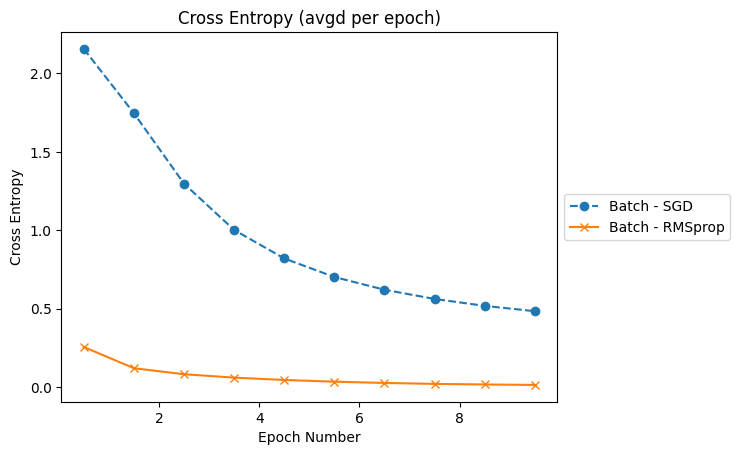

In [202]:
plt.plot(epoch_data_avgd_11, loss_data_avgd_11, 'o--', label = 'Batch - SGD'); 
plt.plot(epoch_data_avgd_12, loss_data_avgd_12, 'x-', label = 'Batch - RMSprop');
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (avgd per epoch)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

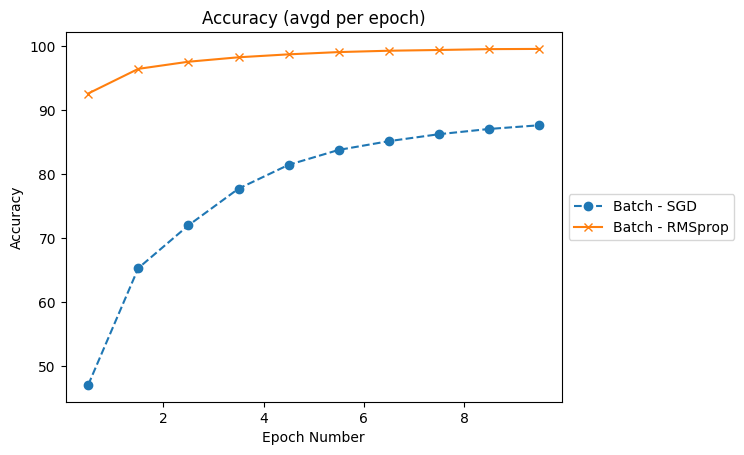

In [203]:
plt.plot(epoch_data_avgd_11, accuracy_data_11, 'o--', label = 'Batch - SGD'); 
plt.plot(epoch_data_avgd_12, accuracy_data_12, 'x-', label = 'Batch - RMSprop');
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Accuracy (avgd per epoch)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [204]:
batch_size = 50
n_epochs = 10
f = MyNeuralNet(batch_size=batch_size)
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=0, 
    worker_init_fn = lambda id: np.random.seed(id))
epoch_data_21, loss_data_21, accuracy_data_21 = train_model_MNIST(train_dl, f, n_epochs=n_epochs, batch_size=batch_size, optimizer = 'SGD')

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [205]:
f = MyNeuralNet(batch_size=batch_size)
epoch_data_22, loss_data_22, accuracy_data_22 = train_model_MNIST(train_dl, f, n_epochs=n_epochs, batch_size=batch_size, optimizer = 'RMSprop')

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [206]:
epoch_data_22.shape

(12000,)

In [207]:
len(train_dl)

1200

In [208]:
epoch_data_avgd_21 = epoch_data_21.reshape(n_epochs,-1).mean(axis=1); epoch_data_avgd_22 = epoch_data_22.reshape(n_epochs,-1).mean(axis=1)
loss_data_avgd_21 = loss_data_21.reshape(n_epochs,-1).mean(axis=1); loss_data_avgd_22 = loss_data_22.reshape(n_epochs,-1).mean(axis=1); 

In [209]:
epoch_21 = epoch_data_avgd_21.tolist()
epoch_21.insert(0,epoch_data_21[0])
loss_21 = loss_data_avgd_21.tolist()
loss_21.insert(0, loss_data_21[0])
epoch_22 = epoch_data_avgd_22.tolist()
epoch_22.insert(0,epoch_data_22[0])
loss_22 = loss_data_avgd_22.tolist()
loss_22.insert(0, loss_data_22[0])


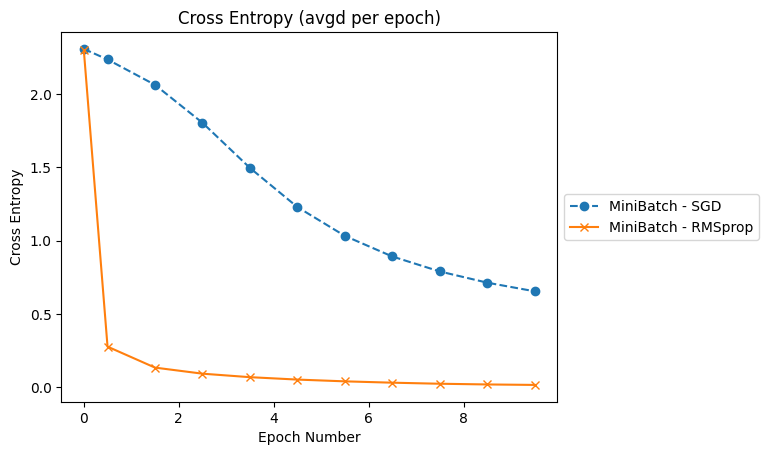

In [210]:
plt.plot(epoch_21, loss_21, 'o--', label = 'MiniBatch - SGD'); 
plt.plot(epoch_22, loss_22, 'x-', label = 'MiniBatch - RMSprop');
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (avgd per epoch)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [211]:
epoch_21 = epoch_data_avgd_21.tolist()
epoch_21.insert(0,epoch_data_21[0])
acc_21 = accuracy_data_21.tolist()
acc_21.insert(0, accuracy_data_11[0])
epoch_22 = epoch_data_avgd_22.tolist()
epoch_22.insert(0,epoch_data_22[0])
acc_22 = accuracy_data_22.tolist()
acc_22.insert(0, accuracy_data_12[0])

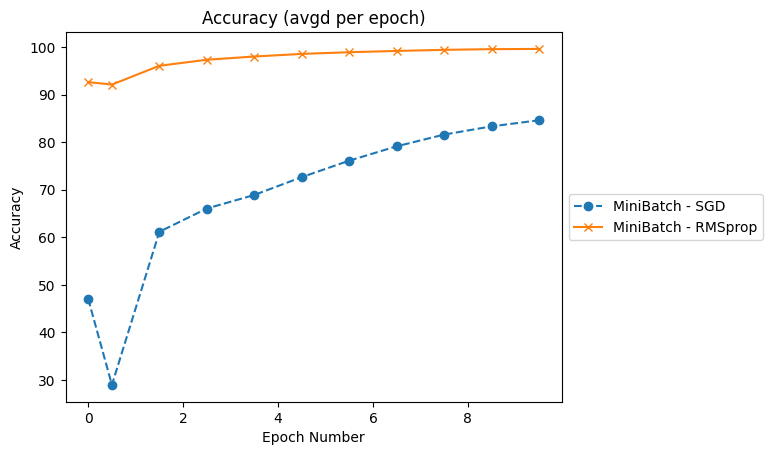

In [212]:
plt.plot(epoch_21, acc_21, 'o--', label = 'MiniBatch - SGD'); 
plt.plot(epoch_22, acc_22, 'x-', label = 'MiniBatch - RMSprop');
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Accuracy (avgd per epoch)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

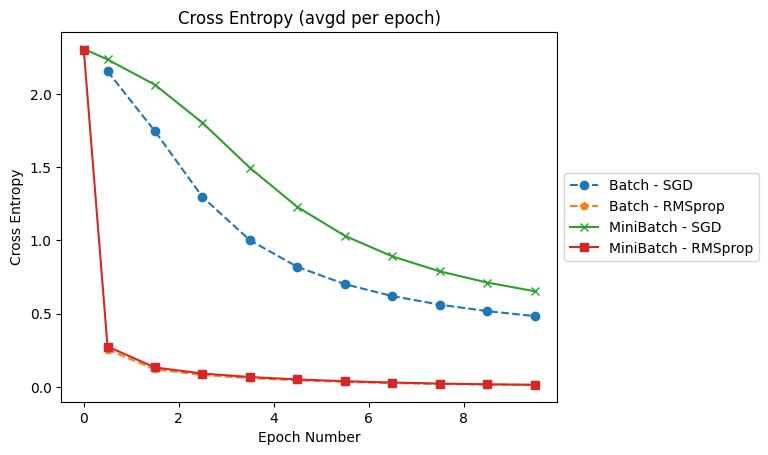

In [213]:
plt.plot(epoch_data_avgd_11, loss_data_avgd_11, 'o--', label = 'Batch - SGD'); plt.plot(epoch_data_avgd_12, loss_data_avgd_12, 'p--', label = 'Batch - RMSprop')
plt.plot(epoch_21, loss_21, 'x-', label = 'MiniBatch - SGD'); plt.plot(epoch_22, loss_22, 's-', label = 'MiniBatch - RMSprop')
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (avgd per epoch)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

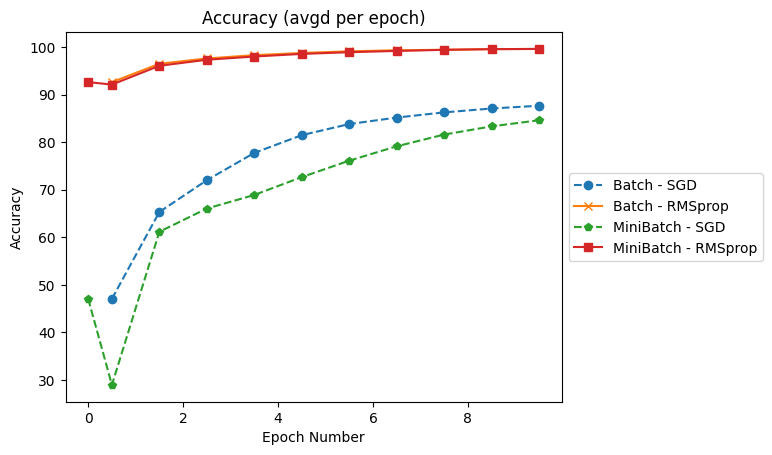

In [214]:
plt.plot(epoch_data_avgd_11, accuracy_data_11, 'o--', label = 'Batch - SGD'); 
plt.plot(epoch_data_avgd_12, accuracy_data_12, 'x-', label = 'Batch - RMSprop');
plt.plot(epoch_21, acc_21, 'p--', label = 'MiniBatch - SGD'); 
plt.plot(epoch_22, acc_22, 's-', label = 'MiniBatch - RMSprop');
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Accuracy (avgd per epoch)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

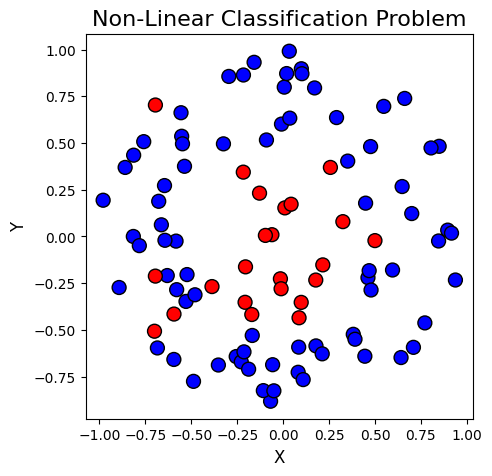

In [215]:
csvFile = readDataPath + 'new_circle_data.csv'
data = np.loadtxt(csvFile,delimiter = ',')
x = data[:-1,:].T
y = data[-1,:].T
data = pd.DataFrame(data)
data = data.T
data.columns=["X", "Y", "Label"]
plt.figure(figsize=(5, 5))
col = np.where(data["Label"]==1,'r','b')
plt.scatter(data["X"],data["Y"],s=100,c=col, edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Non-Linear Classification Problem', fontsize=16)
plt.show()

In [216]:
ind0 = np.where(y==-1)[0]
ind1 = np.where(y==1)[0]
y = np.array([0 if k in ind0 else 1 for k in range(len(y))]) #for BCE loss

In [217]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [218]:
batch_size = 10
x_tensor = torch.from_numpy(x).type(torch.float)
y_tensor = torch.from_numpy(y).type(torch.float)

In [219]:
from torch.utils.data import TensorDataset
my_dataset = TensorDataset(x_tensor,y_tensor) # create your datset
my_dataloader = DataLoader(my_dataset, batch_size=batch_size)

In [220]:
class MyNeuralNet2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.R = nn.ReLU()
    def forward(self,x):
        return self.layer_3(self.R(self.layer_2(self.R(self.layer_1(x)))))

In [221]:
def train_model(dl, f, n_epochs, batch_size, optimizer):
    # Optimization
    if (optimizer == 'SGD'):
        opt = SGD(f.parameters(), lr=0.1)
    elif (optimizer == 'RMSprop'):
        opt = RMSprop(f.parameters(), lr=0.1)
    elif (optimizer == 'Adam'):
        opt = Adam(f.parameters(), lr=0.1)
    accuracy = []
    #L = nn.BCELoss()
    L = nn.BCEWithLogitsLoss()
    # Train model
    losses = []
    epochs = []
    for epoch in range(0,n_epochs):
        correct = 0
        #print(f'Epoch {epoch}')
        N = len(dl)
        for i, (x, y) in enumerate(dl): #loop 60000/batchsize
            output_logits = f(x)
            output_logits = output_logits.squeeze()
            output = torch.round(torch.sigmoid(output_logits))
            loss_value = L(output_logits, y.squeeze()) 
            correct += torch.eq(y, output).sum().item()
            opt.zero_grad()
            loss_value.backward() 
            opt.step() 
            epochs.append(epoch+i/N)
            losses.append(loss_value.item())
        accuracy.append(100 * correct / 100)
        if epoch % 1000 == 0:
            #print('output: ', output)
            #print('target: ', y)
            print(f"Epoch: {epoch} | Accuracy: {accuracy[epoch]:.2f}% ")
        
    return np.array(epochs), np.array(losses), np.array(accuracy)

In [222]:
n_epochs = 7000
f = MyNeuralNet2D()
epoch_data_unormalizedBatch, loss_data_unormalizedBatch, accuracy_data_unormalizedBatch = train_model(my_dataloader, f, n_epochs=n_epochs, batch_size=batch_size, optimizer = 'SGD')

Epoch: 0 | Accuracy: 56.00% 
Epoch: 1000 | Accuracy: 93.00% 
Epoch: 2000 | Accuracy: 97.00% 
Epoch: 3000 | Accuracy: 99.00% 
Epoch: 4000 | Accuracy: 99.00% 
Epoch: 5000 | Accuracy: 99.00% 
Epoch: 6000 | Accuracy: 99.00% 


/var/folders/h4/_y25lq397kbgj8ll1k7bwkww0000gn/T/ipykernel_28652/3642533594.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x[:, 0], x[:, 1], c=col, s=40, cmap=plt.cm.RdYlBu)


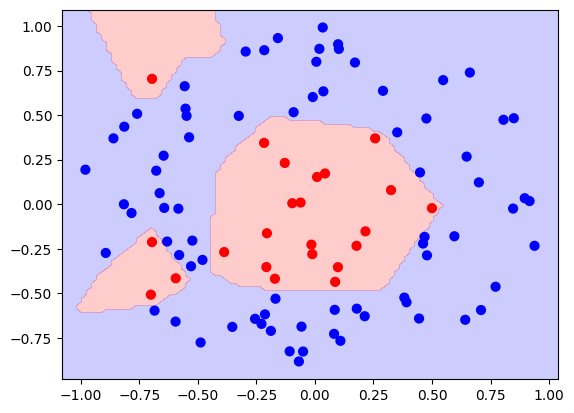

In [223]:
# Setup prediction boundaries and grid
x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

# Make features
X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

# Make predictions
f.eval()
with torch.inference_mode():
    y_logits = f(X_to_pred_on)

# Test for multi-class or binary and adjust logits to prediction labels
y_pred = torch.round(torch.sigmoid(y_logits))  # binary

# Reshape preds and plot
y_pred = y_pred.reshape(xx.shape).detach().numpy()
plt.contourf(xx, yy, y_pred+1, levels = range(0,2+1), alpha=0.2, colors = ['blue', 'red'])
plt.scatter(x[:, 0], x[:, 1], c=col, s=40, cmap=plt.cm.RdYlBu)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

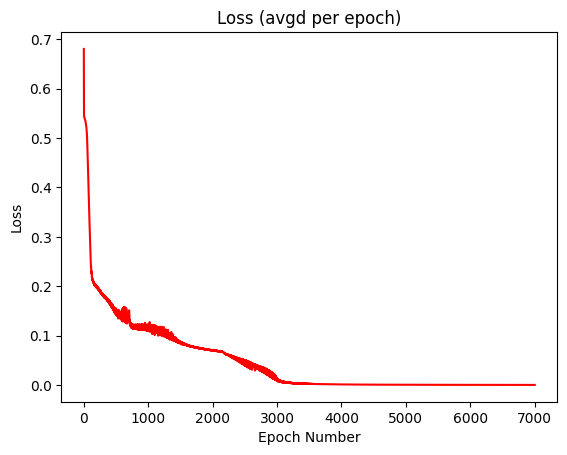

In [224]:
epoch_data_avgd_unormalizedBatch = epoch_data_unormalizedBatch.reshape(n_epochs,-1).mean(axis=1);
loss_data_avgd_unormalizedBatch = loss_data_unormalizedBatch.reshape(n_epochs,-1).mean(axis=1);
plt.plot(epoch_data_avgd_unormalizedBatch,loss_data_avgd_unormalizedBatch,'r-')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.title('Loss (avgd per epoch)')
plt.show()


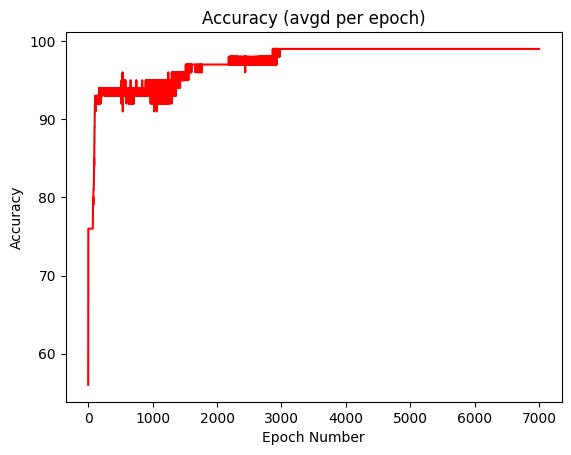

In [225]:
plt.plot(range(0,n_epochs),accuracy_data_unormalizedBatch, 'r-')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Accuracy (avgd per epoch)')
plt.show()

In [226]:
class MyNeuralNetBatchNormalization_MNIST(nn.Module):
    def __init__(self, batch_size):
        super().__init__()
        self.Matrix1 = nn.Linear(28**2,100)
        self.normalization1 = nn.BatchNorm1d(100)
        self.Matrix2 = nn.Linear(100,50)
        self.normalization2 = nn.BatchNorm1d(50)
        self.Matrix3 = nn.Linear(50,10)
        #self.R = nn.ReLU()
        self.R = nn.Tanh()
        self.batch_size = batch_size
    def forward(self,x):
        x = x.view(-1,28**2) #keep batch, and combine remaining
        x = self.normalization1(self.R(self.Matrix1(x)))
        x = self.normalization2(self.R(self.Matrix2(x)))
        x = self.Matrix3(x)
        if (self.batch_size==1):
            x_returned = x
        else:
            x_returned = x.squeeze()
        return x

In [227]:
batch_size = 50
n_epochs = 10
f = MyNeuralNetBatchNormalization_MNIST(batch_size=batch_size)
train_dl = DataLoader(train_ds, batch_size=batch_size)
epoch_data_21_batch_normalized, loss_data_21_batch_normalized, accuracy_data_21_batch_normalized = train_model_MNIST(train_dl, f, n_epochs=n_epochs, batch_size=batch_size, optimizer = 'SGD')

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [228]:
epoch_data_avgd_21_batch_normalized = epoch_data_21_batch_normalized.reshape(n_epochs,-1).mean(axis=1);
loss_data_avgd_21_batch_normalized = loss_data_21_batch_normalized.reshape(n_epochs,-1).mean(axis=1);

In [229]:
epoch_21_batch_normalized = epoch_data_avgd_21_batch_normalized.tolist()
epoch_21_batch_normalized.insert(0,epoch_data_21_batch_normalized[0])
loss_21_batch_normalized = loss_data_avgd_21_batch_normalized.tolist()
loss_21_batch_normalized.insert(0, loss_data_21_batch_normalized[0])

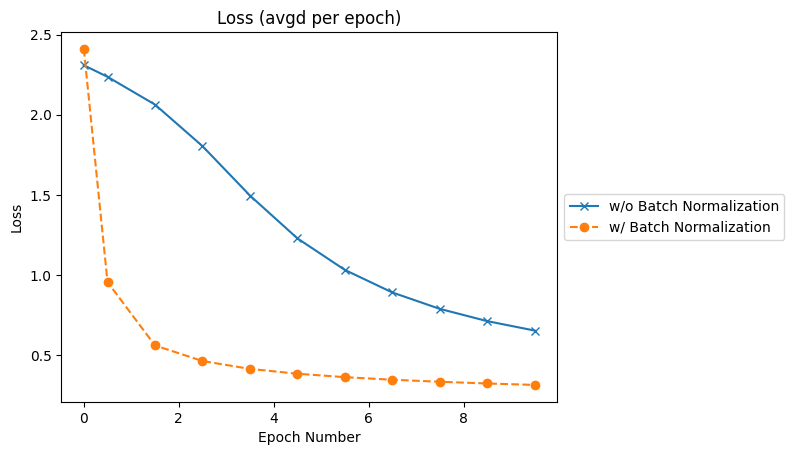

In [230]:
plt.plot(epoch_21, loss_21, 'x-', label = 'w/o Batch Normalization');
plt.plot(epoch_21_batch_normalized, loss_21_batch_normalized, 'o--', label = 'w/ Batch Normalization'); 
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.title('Loss (avgd per epoch)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [231]:
acc_21_batch_normalized = accuracy_data_21_batch_normalized.tolist()
acc_21_batch_normalized.insert(0, acc_21[0])

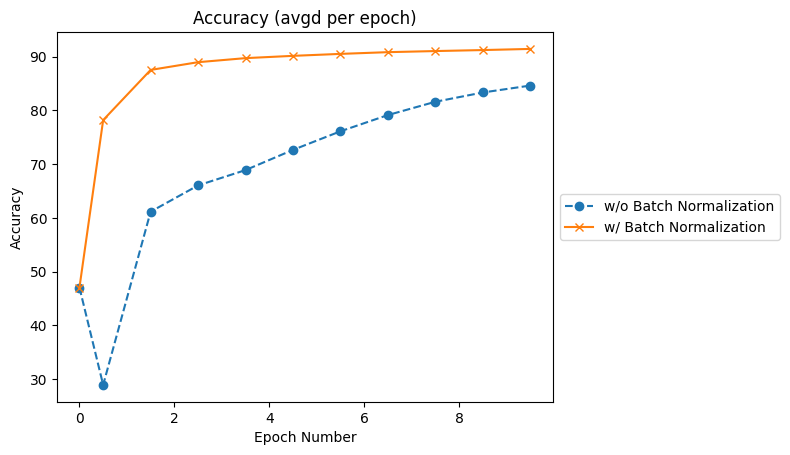

In [232]:
plt.plot(epoch_21, acc_21, 'o--', label = 'w/o Batch Normalization'); 
plt.plot(epoch_21, acc_21_batch_normalized, 'x-', label = 'w/ Batch Normalization');
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Accuracy (avgd per epoch)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Cross-validation via Early Stopping

With any technique for cross-validation, our ideal is to find a model that provides the lowest possible error on a validation set. 

With early stopping we do this by stopping the minimization of a cost function (which is measuring training error) when validation error reaches its lowest point.

There are a number of important engineering details associated with making an effective early stopping procedure. These include:

- **When is validation error really at its lowest?** While generally speaking validation error decreases at the start of an optimization run and eventually increases (making somewhat of a 'U' shape) it can certainly fluctuate up and down during optimization. Therefore it is not all together obvious when the validation error has indeed reached its lowest point unless the optimization process is performed to completion. To deal with this peculiarity, often in practice a reasonable engineering choice is made as to when to stop based on how long it has been since the validation error has *not* decreased.


- **Large (local optimization) steps are to be avoided.** The idea with early stopping is to measure training and validation errors often as an optimization procedure makes progress, so that the procedure can be halted when validation error is low. If one uses a local optimization procedure that takes very large steps (e.g., Newton's method) optimization can quickly lead to weights that overfit the training data. In other words, a set of weights that provide minimal validation error can be skipped over entirely. Thus when employing early stopping one needs to use a local optimization method with moderate-length steps.


- **Validation error should be measured often.** Validation error should be measured frequently during the minimization process in order to determine a validation error minimizing set of weights.  When employing a mini-batch / stochastic first order method validation error should be measured *several times per epoch* to avoid taking too large of steps without measuring validation error (and perhaps skipping over error minimizing weights entirely).

Notice that because we are stopping our optimization procedure early based on validation error, that different weights (and correspondingly different shape nonlinearities) can be found via early stopping depending on the initialization of the local method used and the trajectory of the optimization. 

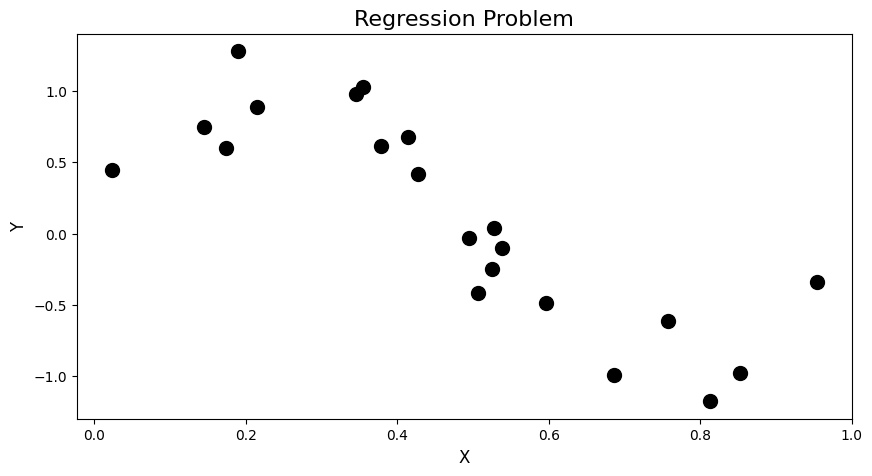

In [233]:
csvname = readDataPath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:].T # up to last row (exclusive) of data & all columns
y = data[-1:,:].T # last row of data & all columns
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Regression Problem', fontsize=16)
plt.show()

In [234]:
x = torch.from_numpy(x.reshape(-1,1)).float()
y = torch.from_numpy(y.reshape(-1,1)).float()

In [235]:
X_train, X_val, y_train,y_val =  train_test_split(x, y, test_size=0.333, random_state=0)

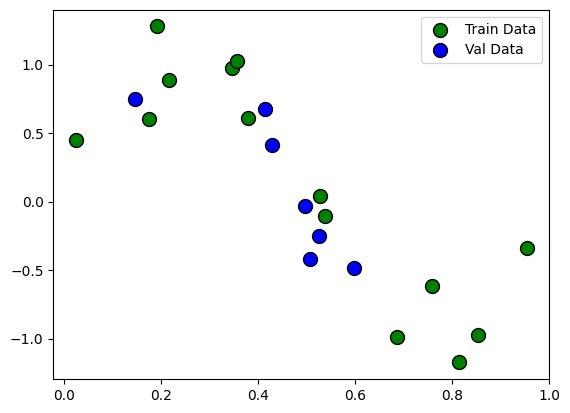

In [236]:
plt.scatter(X_train,y_train,s=100,facecolors='g', edgecolors='k', label = 'Train Data')
plt.scatter(X_val,y_val,s=100,facecolors='b', edgecolors='k', label = 'Val Data')
plt.legend()
plt.show()

In [237]:
class NNReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=1, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=5)
        self.layer_3 = nn.Linear(in_features=5, out_features=5)
        self.layer_4 = nn.Linear(in_features=5, out_features=5)
        self.layer_5 = nn.Linear(in_features=5, out_features=1)
        self.ACTIVATION = nn.Tanh()

    def forward(self, x):
        x = self.ACTIVATION(self.layer_1(x))
        x = self.ACTIVATION(self.layer_2(x))
        x = self.ACTIVATION(self.layer_3(x))
        x = self.ACTIVATION(self.layer_4(x))
        x = self.layer_5(x)
        return x#self.layer_4(self.ACTIVATION(self.layer_3(self.ACTIVATION(self.layer_2(self.ACTIVATION(self.layer_1(x)))))))

In [238]:
# Fit the model

model = NNReg()
x_predicted = np.linspace(min(x)-0.05,max(x)+0.05,1000).reshape(-1, 1)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

torch.manual_seed(42)
epochs = 100000
epoch_1 = 2000
epoch_2 = 34276
train_loss_array = []
val_loss_array = []
for epoch in range(epochs):
    # 1. Forward pass
    model.train()
    y_train_pred = model(X_train)
    # 2. Calculate loss and accuracy
    train_loss = loss_fn(y_train_pred, y_train)
    train_loss_array.append(train_loss.item())
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    train_loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        y_val_pred = model(X_val)
        val_loss = loss_fn(y_val_pred, y_val)
        val_loss_array.append(val_loss.item())
      #print(val_loss)
    # Print out what's happening
    #if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")
    
    if (epoch ==epoch_1-1):
        train_loss_array_1 = np.array(copy.deepcopy(train_loss_array))
        val_loss_array_1 = np.array(copy.deepcopy(val_loss_array))
        x_predicted_1 = x_predicted
        x_predicted_1 = torch.from_numpy(x_predicted_1.reshape(-1,1)).float()
        y_predicted_1 = model(x_predicted_1).detach()
    elif (epoch == epoch_2-1):
        train_loss_array_2 = np.array(copy.deepcopy(train_loss_array))
        val_loss_array_2 = np.array(copy.deepcopy(val_loss_array))
        x_predicted_2 = x_predicted
        x_predicted_2 = torch.from_numpy(x_predicted_2.reshape(-1,1)).float()
        y_predicted_2 = model(x_predicted_2).detach()
    elif (epoch == epochs-1):
        train_loss_array_3 = np.array(copy.deepcopy(train_loss_array))
        val_loss_array_3 = np.array(copy.deepcopy(val_loss_array))
        x_predicted_3 = x_predicted
        x_predicted_3 = torch.from_numpy(x_predicted_3.reshape(-1,1)).float()
        y_predicted_3 = model(x_predicted_3).detach()

train_loss_array = np.array(train_loss_array)
val_loss_array = np.array(val_loss_array)

Epoch: 0 | Train Loss: 0.66300 | Val Loss: 0.26516
Epoch: 1 | Train Loss: 0.66280 | Val Loss: 0.26492
Epoch: 2 | Train Loss: 0.66259 | Val Loss: 0.26469
Epoch: 3 | Train Loss: 0.66238 | Val Loss: 0.26446
Epoch: 4 | Train Loss: 0.66218 | Val Loss: 0.26423
Epoch: 5 | Train Loss: 0.66198 | Val Loss: 0.26401
Epoch: 6 | Train Loss: 0.66178 | Val Loss: 0.26378
Epoch: 7 | Train Loss: 0.66158 | Val Loss: 0.26356
Epoch: 8 | Train Loss: 0.66138 | Val Loss: 0.26333
Epoch: 9 | Train Loss: 0.66118 | Val Loss: 0.26311
Epoch: 10 | Train Loss: 0.66099 | Val Loss: 0.26289
Epoch: 11 | Train Loss: 0.66080 | Val Loss: 0.26267
Epoch: 12 | Train Loss: 0.66060 | Val Loss: 0.26246
Epoch: 13 | Train Loss: 0.66041 | Val Loss: 0.26224
Epoch: 14 | Train Loss: 0.66022 | Val Loss: 0.26203
Epoch: 15 | Train Loss: 0.66003 | Val Loss: 0.26181
Epoch: 16 | Train Loss: 0.65984 | Val Loss: 0.26160
Epoch: 17 | Train Loss: 0.65966 | Val Loss: 0.26139
Epoch: 18 | Train Loss: 0.65947 | Val Loss: 0.26118
Epoch: 19 | Train Loss

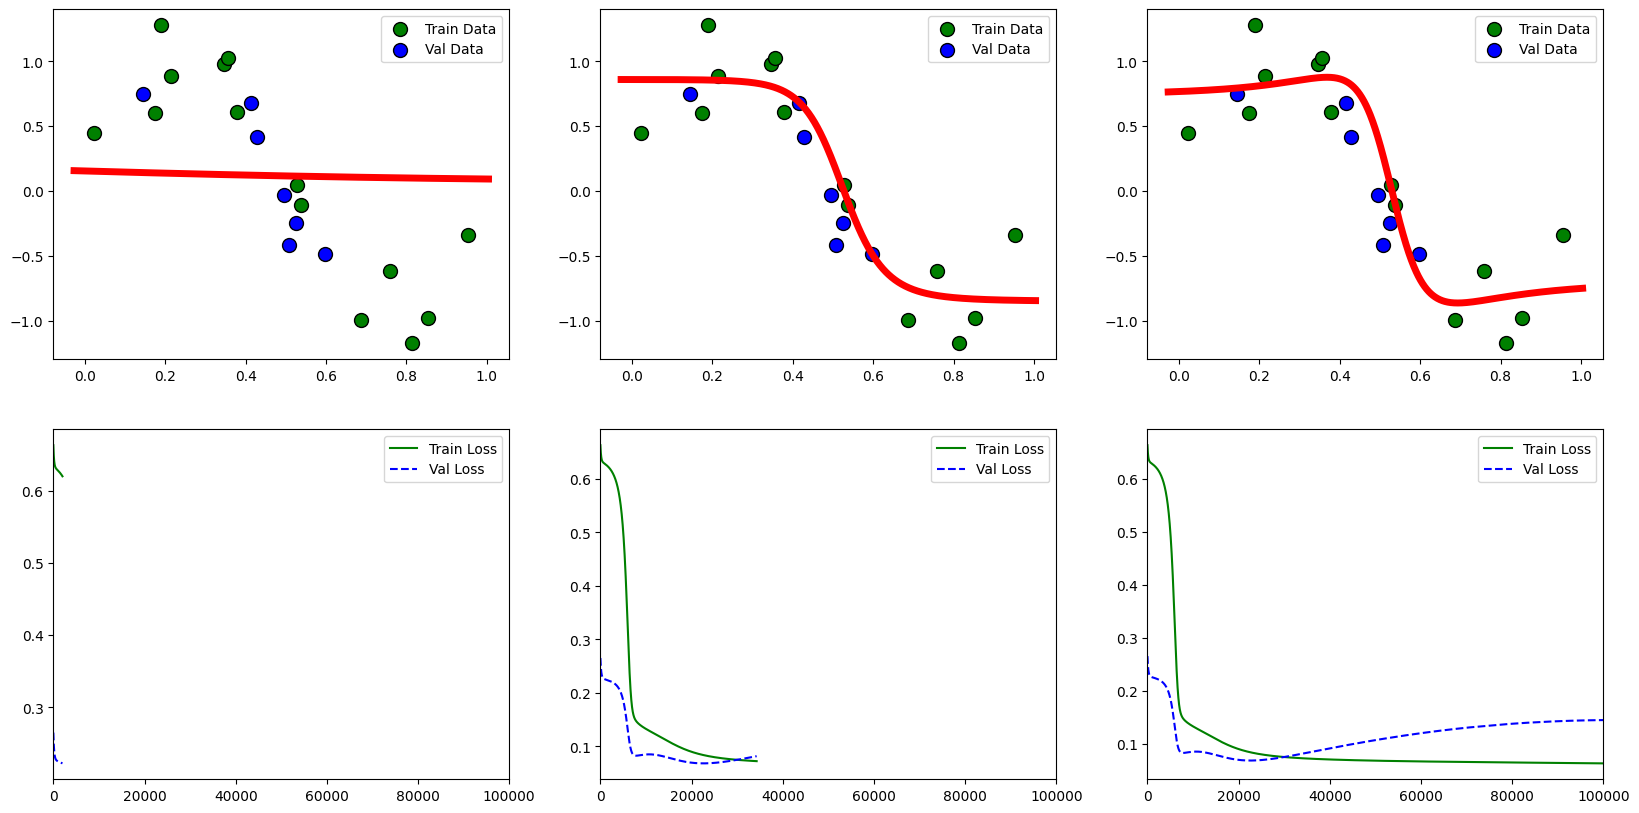

In [239]:
fig, axs = plt.subplots(2,3, figsize = (20,10))
x_predicted  = x_predicted_1
for i in range(0,3):
    if (i==0):
        loss_train = train_loss_array_1
        loss_val = val_loss_array_1
        y_predicted = y_predicted_1
        axs[1,i].plot(range(0,epoch_1),loss_train, 'g-', label = 'Train Loss')
        axs[1,i].plot(range(0,epoch_1),loss_val, 'b--', label = 'Val Loss')
    elif (i==1):
        loss_train = train_loss_array_2
        loss_val = val_loss_array_2
        y_predicted = y_predicted_2
        axs[1,i].plot(range(0,epoch_2),loss_train, 'g-', label = 'Train Loss')
        axs[1,i].plot(range(0,epoch_2),loss_val, 'b--', label = 'Val Loss')
    elif (i==2):
        loss_train = train_loss_array
        loss_val = val_loss_array
        y_predicted = y_predicted_3
        axs[1,i].plot(range(0,epochs),loss_train, 'g-', label = 'Train Loss')
        axs[1,i].plot(range(0,epochs),loss_val, 'b--', label = 'Val Loss')
        
    axs[0,i].scatter(X_train,y_train,s=100,facecolors='g', edgecolors='k', label = 'Train Data')
    axs[0,i].scatter(X_val,y_val,s=100,facecolors='b', edgecolors='k', label = 'Val Data')
    axs[0,i].plot(x_predicted,y_predicted,'r-',linewidth=5)
    axs[1,i].legend()
    axs[1,i].set_xlim([0, epochs])
    axs[0,i].legend()
